In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import PowerTransformer

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras import optimizers
from sklearn.model_selection import train_test_split

sns.set()
random_state = 123_456
np.random.seed(random_state)

error_tolerance_percentage = 2.5
look_back = 0

/usr/local/Cellar/jupyterlab/1.2.4/libexec/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
df = pd.read_csv('fuel-prices/all_features_combined.csv', index_col='date', dtype={'price': np.int32, 
                 'tapis_oil_price': np.int32, 'national_avg_price': np.int32}, parse_dates=True)
df.set_index(pd.date_range(min(df.index), periods=df.shape[0], freq='D'), inplace=True, verify_integrity=True)

In [3]:
df

price  tapis_oil_price  national_avg_price  sgd_exchange_rate  \
2017-01-01   1417             5863                1184             1.0425   
2017-01-02   1436             5863                1184             1.0425   
2017-01-03   1409             5863                1184             1.0479   
2017-01-04   1542             5761                1186             1.0489   
2017-01-05   1582             5779                1191             1.0479   
...           ...              ...                 ...                ...   
2019-12-27   1608             7445                1336             0.9435   
2019-12-28   1589             7456                1349             0.9434   
2019-12-29   1579             7456                1349             0.9434   
2019-12-30   1602             7456                1349             0.9434   
2019-12-31   1609             7411                1357             0.9444   

            usd_exchange_rate  volume_in_ml  
2017-01-01             0.7186          18.7  
2017-01-02             0.7186          18.7  
2017-01-03             0.7226          18.7  
2017-01-04             0.7284          18.7  
2017-01-05             0.7337          18.7  
...                       ...           ...  
2019-12-27             0.6978          14.3  
2019-12-28             0.6995          14.3  
2019-12-29             0.6995          14.3  
2019-12-30             0.6995          14.3  
2019-12-31             0.7022          14.3  

[1095 rows x 6 columns]

In [4]:
features = ['price','tapis_oil_price','national_avg_price']
# features = ['price']
df.shape

(1095, 6)

In [5]:
df = df[features]

In [6]:
df_train, df_test = train_test_split(df, test_size=0.1, shuffle=False)
del df
df_train.shape

(985, 3)

In [7]:
df_test[:5]

price  tapis_oil_price  national_avg_price
2019-09-13   1756             6329                1299
2019-09-14   1725             6793                1310
2019-09-15   1720             6793                1310
2019-09-16   1718             6793                1310
2019-09-17   1696             7134                1311

In [8]:
# df_train.describe()

In [9]:
def get_relative_accuracy(y_test, y_hat, tolerance_percentage):
    it = np.nditer(y_test, flags=['f_index'])
    non_error_count = 0
    
    while not it.finished:
        upper_limit = it[0] * (1 + tolerance_percentage / 100)
        lower_limit = it[0] - (upper_limit - it[0])
        non_error_count += 1 if y_hat[it.index] < upper_limit and y_hat[it.index] > lower_limit else 0
        it.iternext()
        
    return non_error_count / y_test.size

In [10]:
should_standard_scale = True

if should_standard_scale:
    ct = make_column_transformer((MinMaxScaler(), features), verbose=True)
#     ct = make_column_transformer((PowerTransformer(method='box-cox'), features), verbose=True)
#     ct = make_column_transformer((PowerTransformer(method='yeo-johnson'), features), verbose=True)

    result = ct.fit_transform(df_train)
    df_temp = pd.DataFrame(result, columns=features, index=df_train.index)

    for column in features:
        del df_train[column]

    df_train = df_train.merge(df_temp, left_index=True, right_index=True, validate='one_to_one')
    
    result = ct.transform(df_test)
    df_temp = pd.DataFrame(result, columns=features, index=df_test.index)

    for column in features:
        del df_test[column]

    df_test = df_test.merge(df_temp, left_index=True, right_index=True, validate='one_to_one')
    del df_temp
    
    scaler = ct.transformers_[0][1]

[ColumnTransformer] .. (1 of 1) Processing minmaxscaler, total=   0.0s


In [11]:
ct.transformers_

[('minmaxscaler',
  MinMaxScaler(copy=True, feature_range=(0, 1)),
  ['price', 'tapis_oil_price', 'national_avg_price'])]

In [12]:
# for i in range(look_back):
#     df_train['pr_min_{:02d}'.format(i + 1)] = df_train.price.shift(i + 1)
#     df_test['pr_min_{:02d}'.format(i + 1)] = df_test.price.shift(i + 1)
    
# df_train.dropna(inplace=True)
# df_test.dropna(inplace=True)

In [13]:
df_train[:5]

price  tapis_oil_price  national_avg_price
2017-01-01  0.253448         0.296510            0.277916
2017-01-02  0.286207         0.296510            0.277916
2017-01-03  0.239655         0.296510            0.277916
2017-01-04  0.468966         0.273839            0.282878
2017-01-05  0.537931         0.277840            0.295285

In [14]:
df_test[:5]

price  tapis_oil_price  national_avg_price
2019-09-13  0.837931         0.400089            0.563275
2019-09-14  0.784483         0.503223            0.590571
2019-09-15  0.775862         0.503223            0.590571
2019-09-16  0.772414         0.503223            0.590571
2019-09-17  0.734483         0.579018            0.593052

In [15]:
y_train = df_train.price.shift(-1)
y_train.drop(y_train[y_train.index == '2019-09-12'].index, inplace=True)
df_train.drop(df_train[df_train.index == '2019-09-12'].index, inplace=True)
y_train[:5]

2017-01-01    0.286207
2017-01-02    0.239655
2017-01-03    0.468966
2017-01-04    0.537931
2017-01-05    0.446552
Freq: D, Name: price, dtype: float64

In [16]:
y_test = df_test.price.shift(-1)
y_test.drop(y_test[y_test.index == '2019-12-31'].index, inplace=True)
df_test.drop(df_test[df_test.index == '2019-12-31'].index, inplace=True)
y_test[:5]

2019-09-13    0.784483
2019-09-14    0.775862
2019-09-15    0.772414
2019-09-16    0.734483
2019-09-17    0.691379
Freq: D, Name: price, dtype: float64

In [17]:
df_train.shape

(984, 3)

In [18]:
df_test.shape

(109, 3)

In [19]:
y_train.shape

(984,)

In [20]:
y_test.shape

(109,)

In [21]:
def build_timeseries(mat, y_col_index):
    """
    Converts ndarray into timeseries format and supervised data format. Takes first TIME_STEPS
    number of rows as input and sets the TIME_STEPS+1th data as corresponding output and so on.
    :param mat: ndarray which holds the dataset
    :param y_col_index: index of column which acts as output
    :return: returns two ndarrays-- input and output in format suitable to feed
    to LSTM.
    """
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - look_back
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, look_back, dim_1))
    y = np.zeros((dim_0,))
    print("dim_0",dim_0)
    
    for i in range(dim_0):
        x[i] = mat[i:look_back+i]
        y[i] = mat[look_back+i, y_col_index]
#         if i < 10:
#           print(i,"-->", x[i,-1,:], y[i])

    print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [22]:
# df_train[:5]

In [23]:
X_train = df_train.values
X_train = np.reshape(X_train, (df_train.shape[0], look_back + 1, len(features)))
X_train.shape
# x, y = build_timeseries(df_train.values, 0)
# df_train
# x[:5]

(984, 1, 3)

In [24]:
# X_train

In [25]:
X_test = df_test.values
X_test = np.reshape(X_test, (df_test.shape[0], look_back + 1, len(features)))
X_test.shape

(109, 1, 3)

In [26]:
y_train = y_train.values

In [27]:
y_test = y_test.values

In [28]:
model = Sequential()

In [29]:
use_simple_model = True

if use_simple_model:
    model.add(LSTM(100, batch_input_shape=(1, look_back + 1, len(features)), stateful=False))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
else:
        
    model.add(LSTM(100, batch_input_shape=(1, look_back + 1, len(features)),
                   dropout=0.0, recurrent_dropout=0.0, stateful=True, return_sequences=True,
                   kernel_initializer='random_uniform'))

    model.add(Dropout(0.4))
    model.add(LSTM(60, dropout=0.0))
    model.add(Dropout(0.4))
    model.add(Dense(20,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))

    optimizer = optimizers.RMSprop(lr=0.0001)
    model.compile(loss='mean_squared_error', optimizer=optimizer)

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 100)                  41600     
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    101       
Total params: 41,701
Trainable params: 41,701
Non-trainable params: 0
_________________________________________________________________


In [31]:
history = model.fit(X_train, y_train, epochs=16, verbose=1, batch_size=1, shuffle=False, 
                    validation_data=(X_test, y_test))

Train on 984 samples, validate on 109 samples
Epoch 1/16
984/984 [==============================] - 2s 2ms/step - loss: 0.0102 - val_loss: 0.0043
Epoch 2/16
984/984 [==============================] - 1s 973us/step - loss: 0.0035 - val_loss: 0.0031
Epoch 3/16
984/984 [==============================] - 1s 931us/step - loss: 0.0032 - val_loss: 0.0030
Epoch 4/16
984/984 [==============================] - 1s 927us/step - loss: 0.0032 - val_loss: 0.0030
Epoch 5/16
984/984 [==============================] - 1s 920us/step - loss: 0.0032 - val_loss: 0.0030
Epoch 6/16
984/984 [==============================] - 1s 930us/step - loss: 0.0031 - val_loss: 0.0030
Epoch 7/16
984/984 [==============================] - 1s 926us/step - loss: 0.0031 - val_loss: 0.0030
Epoch 8/16
984/984 [==============================] - 1s 936us/step - loss: 0.0030 - val_loss: 0.0030
Epoch 9/16
984/984 [==============================] - 1s 936us/step - loss: 0.0030 - val_loss: 0.0030
Epoch 10/16
984/984 [=================

In [32]:
# y_test = scaler.inverse_transform(y_test.reshape(-1,1)).reshape(1,-1)[0]
bb = y_test.reshape(-1,1)
# bb
aa = np.concatenate((bb, bb, bb), axis=1)
y_test = scaler.inverse_transform(aa).T[0]

In [33]:
y_hat = model.predict(X_test, batch_size=1)

In [34]:
# y_hat = np.rint(scaler.inverse_transform(y_hat).reshape(1,-1)[0])
bb = y_hat.reshape(-1,1)
# bb
aa = np.concatenate((bb, bb, bb), axis=1)
y_hat = np.rint(scaler.inverse_transform(aa).T[0])

In [35]:
get_relative_accuracy(y_test, y_hat, error_tolerance_percentage)

0.8440366972477065

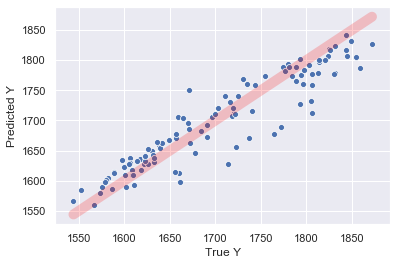

In [36]:
line_x_y = [math.floor(min(y_test.min(),y_hat.min())), math.ceil(max(y_test.max(),y_hat.max()))]
_ = plt.plot(line_x_y, line_x_y, linewidth=10, alpha=0.2, color='red')
_ = sns.scatterplot(y_test, y_hat)
_ = plt.ylabel('Predicted Y')
_ = plt.xlabel('True Y')
plt.show()

In [37]:
y_test[:5]

array([1725., 1720., 1718., 1696., 1671.])

In [38]:
y_hat[:5]

array([1741., 1712., 1708., 1706., 1686.], dtype=float32)